In [247]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [127]:
# 隠れ変数を含めたモデル
def p(x,y,a,b):
    p0=(1-a)*np.exp(-x**2/2)/(2*np.pi)**0.5
    p1=a*np.exp(-(x-b)**2/2)/(2*np.pi)**0.5
    return (p0**(1-y))*(p1**y)

In [198]:
# 真の分布からのサンプリング
n=1000
a0=0.3
b0=3
sigma=1
X=[]
for i in range(n):
    u=np.random.random()
    if u<1-a0:
        x=np.random.normal(0,1)
    else:
        x=np.random.normal(b0,1)
    X.append(x)

In [199]:
# 事後分布からのサンプリング
K=5000
A,B=[],[]
alpha=(1,1)
beta=1
gamma=1
mu=0
for k in range(K):
    a=np.random.beta(alpha[0],alpha[1])
    b=np.random.normal(mu,gamma**(-0.5))
    A.append(a)
    B.append(b)
    Y=[]
    for i in range(n):
        u=np.random.random()
        x=X[i]
        if u<p(x,0,a,b)/(p(x,0,a,b)+p(x,1,a,b)):
            Y.append(0)
        else:
            Y.append(1)
    sum_Y=sum(Y)
    sum_XY=sum([X[i]*Y[i] for i in range(n)])
    alpha=alpha[0]+beta*sum_Y,alpha[1]+beta*(n-sum_Y)
    mu=(gamma*mu+beta*sum_XY)/(gamma+beta*sum_Y)
    gamma=gamma+beta*sum_Y

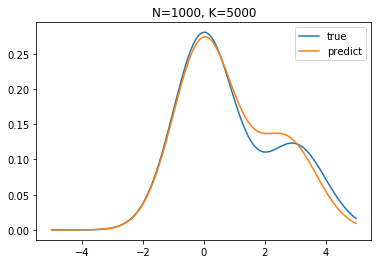

In [214]:
# 予測分布のプロット
x=np.linspace(-5,5,100)
plt.plot(x,p(x,0,a0,b0)+p(x,1,a0,b0),label='true')
def prd(x):
    return sum([p(x,0,A[k],B[k])+p(x,1,A[k],B[k]) for k in range(K)])/K
plt.plot(x,prd(x),label='predict')
plt.title('N={}, K={}'.format(n,K))
plt.legend()
plt.savefig('predict.png')

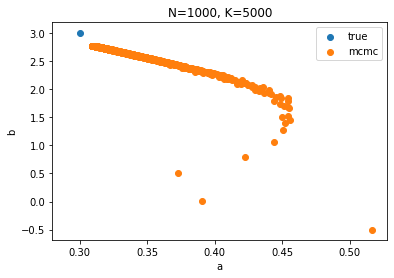

In [213]:
# MCMCのようす
plt.scatter(a0,b0,label='true')
plt.scatter(A,B,label='mcmc')
plt.xlabel('a')
plt.ylabel('b')
plt.title('N={}, K={}'.format(n,K))
plt.legend()
plt.savefig('parameter.png')

In [241]:
def p_j(x,y,a,b):
    p0=(1-a)*np.exp(-x**2/2)/(2*np.pi)**0.5
    p1=a*np.exp(-(x-b)**2/2)/(2*np.pi)**0.5
    return (p0**(1-y))*(p1**y)

def p(x,a,b):
    return p_j(x,0,a,b)+p_j(x,1,a,b)

def prd(x):
    return sum([p(x,A[k],B[k]) for k in range(K)])/K

def main(n=100,a=0.5,b=2,s=1,K=1000,burn=200):
    # n:サンプル数, K:MCMCの遷移回数
    # 真の分布: (1-a)N(0,s)+aN(b,s)からサンプリング
    X=[]
    for i in range(2*n):
        u=np.random.random()
        if u<1-a0:
            x=np.random.normal(0,1)
        else:
            x=np.random.normal(b0,1)
        X.append(x)
    # 事後分布からのサンプリング
    A,B=[],[]
    alpha=(1,1)
    beta=1
    gamma=1
    mu=0
    for k in range(K):
        a=np.random.beta(alpha[0],alpha[1])
        b=np.random.normal(mu,gamma**(-0.5))
        Y=[]
        for i in range(n):
            u=np.random.random()
            x=X[i]
            if u<p_j(x,0,a,b)/p(x,a,b):
                Y.append(0)
            else:
                Y.append(1)
        sum_Y=sum(Y)
        sum_XY=sum([X[i]*Y[i] for i in range(n)])
        alpha=alpha[0]+beta*sum_Y,alpha[1]+beta*(n-sum_Y)
        mu=(gamma*mu+beta*sum_XY)/(gamma+beta*sum_Y)
        gamma=gamma+beta*sum_Y
        if k>=burn:
            A.append(a)
            B.append(b)
    K=K-burn
    # 汎化誤差などを計算
    T=sum([-np.log(prd(X[i])) for i in range(n)])/n
    G=sum([-np.log(prd(X[i])) for i in range(n+1,2*n)])/n
    AIC=T+2/n
    WAIC=T+sum(
        [sum([np.log(p(X[i],A[k],B[k]))**2 for k in range(K)])/K
         -(sum([np.log(p(X[i],A[k],B[k])) for k in range(K)])/K)**2 
         for i in range(n)])/n
    ISCV=sum([np.log(sum([1/p(X[i],A[k],B[k]) for k in range(K)])/K) for i in range(n)])/n
    return G,AIC,WAIC,ISCV

In [257]:
def plot(a=0.5,b=2,s=1,N=100,K=1000,burn=200,ex=100,name='test'):
    G,AIC,WAIC,ISCV=[],[],[],[]
    for _ in range(ex):
        g,aic,waic,iscv=main(a=a,b=b,s=s,n=N,K=K,burn=burn)
        G.append(g)
        AIC.append(aic)
        WAIC.append(waic)
        ISCV.append(iscv)
    plt.cla()
    plt.boxplot((G,AIC,WAIC,ISCV),labels=['G','AIC','WAIC','ISCV'])
    plt.title('{}N(0, {}) + {}N({}, {})'.format(1-a,s,a,b,s))
    plt.savefig('../image/{}.png'.format(name))

1001.47


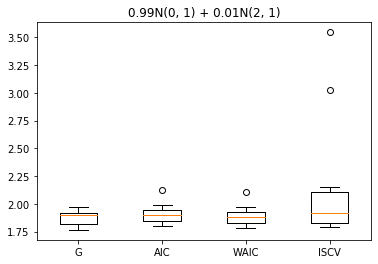

In [259]:
start = time.time()
plot(a=0.5, b=2, s=1, ex=10, name='regular&realizable')
plot(a=0.5, b=2, s=0.8, ex=10, name='regular&unrealizable')
plot(a=0, b=0, s=1, ex=10, name='nonregular&realizable')
plot(a=0, b=0, s=0.8, ex=10, name='nonregular&unrealizable')
plot(a=0.5, b=0.5, s=0.95, ex=10, name='delicate')
plot(a=0.01, b=2, s=1, ex=10, name='unbalanced')
stop = time.time()
print(round(stop-start,2))